In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Semantics

Semantics means the meaning of the words and sentences. Our supervised learning model 'knows' that Jane Austen tends to use the word 'lady' a lot in her writing, and it may know (if you included parts of speech as features) that 'lady' is a noun, but it doesn't know what a lady is. There is nothing in our work on NLP so far that would allow a model to say whether 'queen' or 'car' is more similar to 'lady.'

This severely limits the applicability of our NLP skills! In the absence of semantic information, models can get tripped up on things like synonyms ('milady' and 'lady'). We could modify the spaCy dictionary to include 'lady' as the lemma of 'milady,' then use lemmas for all our analyses, but for this to be an effective approach we would have to go through our entire corpus and identify all synonyms for all words by hand. This approach would also discard subtle differences in the connotations of (words, concepts, ideas, or emotions associated with) 'lady' (elicits thoughts of formal manners and England) and 'milady' (elicits thoughts of medieval ages and Rennaissance Faires).

Unsupervised modeling techniques, and particularly unsupervised neural networks, are perfect for this kind of task. Rather than us 'telling' the model how language works and what each sentence means, we can feed the model a corpus of text and have it 'learn' the rules by identifying recurring patterns within the corpus. Then we can use the trained unsupervised model to understand new sentences as well.

As with supervised NLP, unsupervised models are limited by their corpus- an unsupervised model trained on a medical database is unlikely to know that 'lady' and 'milady' are similar, just as a model trained on Jane Austen wouldn't catch that 'Ehler-Danlos Syndrome' and 'joint hypermobility' describe the same medical condition.


'Document frequency' counts how many sentences a word appears in. 'Collection frequency' counts how often a word appears, total, over all sentences. Let's calculate the df and cf for our sentence set:

## Inverse Document Frequency

Now let's weight the document frequency so that words that occur less often (like 'sketch' and 'dessert') are more influential than words that occur a lot (like 'best').  We will calculate the ratio of total documents (N) divided by df, then take the log (base 2) of the ratio, to get our inverse document frequency number (idf) for each term (t):

$$idf_t=log \dfrac N{df_t}$$

In [3]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to /home/micah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /home/micah/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[u'[ Emma by Jane Austen 1816 ]', u'VOLUME I', u'CHAPTER I', u'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
('Original sentence:', u'A very few minutes more , however , completed the present trial .')
('Tf_idf vector:', {u'minutes': 0.7127450310382584, u'present': 0.701423210857947})


# Dimension reduction
Okay, now we have our vectors, with one vector per paragraph.  It's time to do some dimension reduction.  We use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity):

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])




('Percent variance captured by all components:', 45.20180048835824)
Component 0:
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !"    0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !     0.999291
" Oh !"    0.999291
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633953
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.568195
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .                         0.564325
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , 

## Sentence similarity


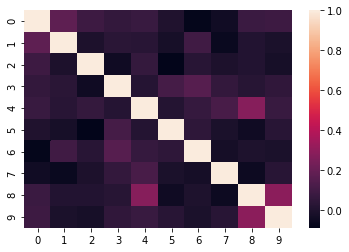

Key:
(0, u'That is _court_ .')
(1, u'" Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."')
(2, u'" How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .')
(3, u'To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very 

In [8]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])